# Audio spectrogram in rocAL 
This example presents a simple rocAL pipeline that loads and decodes audio data along with the calculation of a spectrogram. Small speech dataset is used which consists of samples in .wav format. Illustrated below how to create a pipeline, set_outputs, build, run the pipeline and enumerate over the results.

## Reference implementation

To verify the correctness of rocAL's implementation, we will compare it against librosa.  

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import numpy as np
from amd.rocal.plugin.pytorch import ROCALClassificationIterator
import torch
torch.set_printoptions(threshold=10_000)
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types
# import rocal_pybind.tensor
import sys
import cv2
import os
import matplotlib.pyplot as plt
import librosa as librosa
import librosa.display


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
def show_spectrogram(spec, title, sr, hop_length, y_axis='log', x_axis='time'):
    librosa.display.specshow(spec, sr=16000, y_axis=y_axis, x_axis=x_axis, hop_length=hop_length)
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

## Configuring rocAL pipeline
Configure the pipeline paramters as required by the user.

In [3]:

data_path = "/media/audio_samples/MIVisionX-data/check_1/19-198-0000.wav"
file_list = "/media/audio_samples/MIVisionX-data/txt_file.txt"

_rali_cpu = True
hop_length=512
batch_size = 1
num_threads = 1
device_id = 0
random_seed = random.SystemRandom().randint(0, 2**32 - 1)
print(random_seed)
crop=300

pipe = Pipeline(batch_size=batch_size, num_threads=num_threads,device_id=device_id, seed=random_seed, rocal_cpu=_rali_cpu)
local_rank = 0
world_size = 1

print("*********************************************************************")


    

350109403
Pipeline has been created succesfully
*********************************************************************


[INF]  {compute_optimum_internal_batch_size}  Can run 24 threads simultaneously on this machine
[INF]  {compute_optimum_internal_batch_size}  User batch size 1 Internal batch size set to 1


OK: loaded 98 kernels from libvx_rpp.so
OK: loaded 2 kernels from libvx_amd_media.so


## Librosa implementation
Librosa provides an API to calculate the STFT, producing a complex output (i.e. complex numbers). It is then trivial to calculate the power spectrum from the complex STFT by the following.
Here we load and decoder the audio file and applied spectrogram to it using librosa.


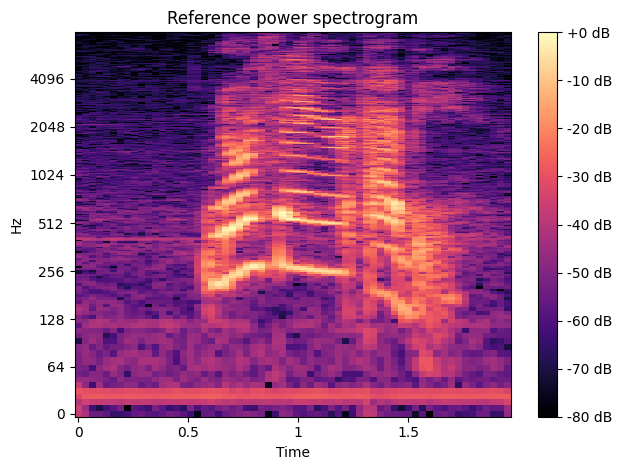

In [4]:
y, sr = librosa.load(data_path,sr=16000)
n_fft=2048
hop_length=512
# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = np.abs(librosa.stft(
    y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann', pad_mode='reflect')) ** 2
spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)
show_spectrogram(spectrogram_librosa_db, 'Reference power spectrogram', sr, hop_length)

In [5]:
data_path = "/media/audio_samples/MIVisionX-data/check_1/"
audio_pipeline = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id, seed=3621326981, rocal_cpu=_rali_cpu)

Pipeline has been created succesfully
OK: loaded 98 kernels from libvx_rpp.so
OK: loaded 2 kernels from libvx_amd_media.so


[INF]  {compute_optimum_internal_batch_size}  Can run 24 threads simultaneously on this machine
[INF]  {compute_optimum_internal_batch_size}  User batch size 1 Internal batch size set to 1


## Audio pipeline 
Here we use the file reader followed by audio decoder. Then the decoded audio data is passed to spectrogram. We enable the output for spectrogram using set_output

In [6]:
with audio_pipeline:
    audio, label = fn.readers.file(
        # **files_arg,
        file_root=data_path,
        file_list=file_list,
        shard_id=0,
        num_shards=8,)
    sample_rate = 16000
    nfft=2048
    window_size=0.02
    window_stride=0.01
    nfilter=80 #nfeatures
    resample = 1
    audio_decode = fn.decoders.audio(audio, file_root=data_path, downmix=True, sample_rate=sample_rate*resample, shard_id=0, num_shards=8)
    spectrogram_audio = fn.spectrogram(
            audio_decode,
            nfft=nfft,
            window_length=2048, # Change to 320
            window_step= 512, # Change to 160
            rocal_tensor_output_type=types.FLOAT,
            
        )
    audio_pipeline.set_outputs(spectrogram_audio)



OUT LIST LEN :  1


[INF]  {rocalAudioFileSourceSingleShard}  Internal buffer size for audio frames = 31440


## Building the Pipeline
Here we are creating the pipeline. In order to use our Pipeline, we need to build it. This is achieved by calling the build function. Then iterator object is created with ROCALClassificationIterator(audio_pipeline)

In [7]:
audio_pipeline.build()
audioIteratorPipeline = ROCALClassificationIterator(audio_pipeline)

Call RPP spectogramReturn from RPP spectogram
 rocAL graph verified[INF]  {output_routine}  Output routine started with 1 to load

RpptSpectrogramLayout layout1 0
RPP RpptSpectrogramLayout layout 0
bool vertical 1

audio_data = audioIteratorPipeline
for i , it in enumerate(audioIteratorPipeline):
    a= it[0].numpy()
    print(type(a))
    print(a.shape)
    b=a[0]
    print(b.shape)
    b= b.flatten()
    print(b.shape)
    print(b)
    plt.plot(b)
    val =0.
    plt.plot(np.arange(-2,2,.5),b, 'x')
    

    
    




## Visualizing outputs

We have plotted the output of the spectrogram to visually compare it with librosa output.

(1025, 62)


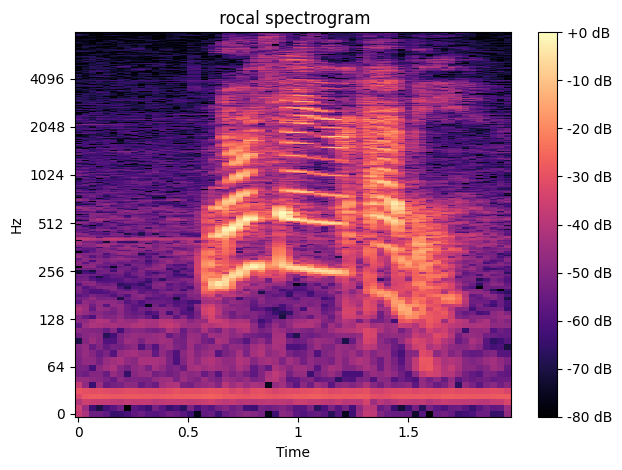

In [8]:
for i , it in enumerate(audioIteratorPipeline):
    num_array=it[0][0].numpy()
    print(num_array.shape)
    spectrogram_db = librosa.power_to_db(num_array, ref=np.max)
    show_spectrogram(spectrogram_db, ' rocal spectrogram', sample_rate, hop_length)



In [9]:
print("Average error: {0:.5f} dB".format(np.mean(np.abs(spectrogram_db - spectrogram_librosa_db))))
assert(np.allclose(spectrogram_db, spectrogram_librosa_db, atol=2))


Average error: 0.01007 dB
